<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Data-Analysis-And-Machine-Learning-Projects/blob/master/3.%20Risk%20Management%20and%20Financial%20Analysis/Insurance%20Dataset%20With%20Regression%20Task/Regression_with_an_Insurance_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Enviroment

In [7]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions list

ref                                                                                deadline             category                reward  teamCount  userHasEntered  
---------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-2      2025-04-01 23:59:00  Featured         2,117,152 Usd        981           False  
https://www.kaggle.com/competitions/konwinski-prize                                2025-03-12 23:59:00  Featured         1,225,000 Usd        156           False  
https://www.kaggle.com/competitions/gemma-language-tuning                          2025-01-15 00:59:00  Analytics          150,000 Usd          0           False  
https://www.kaggle.com/competitions/jane-street-real-time-market-data-forecasting  2025-01-13 23:59:00  Featured           120,000 Usd       3632           False  
https://www.kagg

In [11]:
%%bash
kaggle competitions download -c playground-series-s4e12
unzip /content/playground-series-s4e12.zip

playground-series-s4e12.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/playground-series-s4e12.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Import Libraries

In [14]:
!pip install -q catboost lightgbm xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     GridSearchCV, RandomizedSearchCV)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
import warnings
warnings.filterwarnings('ignore')

# Pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# Import Dataset

In [8]:
train_df = pd.read_csv("/content/train.csv") # Train file
test_df = pd.read_csv("/content/test.csv") # Test file

# Concatenate
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [6]:
df.head(5)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.000,Female,10049.000,Married,1.000,Bachelor's,Self-Employed,22.599,Urban,Premium,2.000,17.000,372.000,5.000,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.000
1,1,39.000,Female,31678.000,Divorced,3.000,Master's,NaN,15.570,Rural,Comprehensive,1.000,12.000,694.000,2.000,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.000
2,2,23.000,Male,25602.000,Divorced,3.000,High School,Self-Employed,47.178,Suburban,Premium,1.000,14.000,NaN,3.000,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.000
3,3,21.000,Male,141855.000,Married,2.000,Bachelor's,NaN,10.938,Rural,Basic,1.000,0.000,367.000,1.000,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.000
4,4,21.000,Male,39651.000,Single,1.000,Bachelor's,Self-Employed,20.376,Rural,Premium,0.000,8.000,598.000,4.000,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.000


# Analyzing Dataset

_Check Train/Test dataframes_

In [11]:
print(train_df.info())
print("-" * 20)
print(train_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [12]:
print(test_df.info())
print("-" * 20)
print(test_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    800000 non-null  int64  
 1   Age                   787511 non-null  float64
 2   Gender                800000 non-null  object 
 3   Annual Income         770140 non-null  float64
 4   Marital Status        787664 non-null  object 
 5   Number of Dependents  726870 non-null  float64
 6   Education Level       800000 non-null  object 
 7   Occupation            560875 non-null  object 
 8   Health Score          750551 non-null  float64
 9   Location              800000 non-null  object 
 10  Policy Type           800000 non-null  object 
 11  Previous Claims       557198 non-null  float64
 12  Vehicle Age           799997 non-null  float64
 13  Credit Score          708549 non-null  float64
 14  Insurance Duration    799998 non-null  float64
 15  

## Extract Features

In [48]:
df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])


df['Year'] =df['Policy Start Date'].dt.year
df['Quarter'] = df['Policy Start Date'].dt.quarter
df['Month'] = df['Policy Start Date'].dt.month
df['Day'] = df['Policy Start Date'].dt.day
df['day_of_week'] = df['Policy Start Date'].dt.day_name()
df['week_of_year'] = df['Policy Start Date'].dt.isocalendar().week

df['day_sin'] = np.sin(2 * np.pi * df['Day'] / 365.0)
df['day_cos'] = np.cos(2 * np.pi * df['Day'] / 365.0)
df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12.0)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12.0)
df['year_sin'] = np.sin(2 * np.pi * df['Year'] / 7.0)
df['year_cos'] = np.cos(2 * np.pi * df['Year'] / 7.0)
df['Group']=(df['Year']-2010)*48+df['Month']*4+df['Day']//7


df['Quarter'] = df['Quarter'].astype('str')
df['Month'] = df['Month'].astype('str')
df['day_of_week'] = df['day_of_week'].astype('str')
df['week_of_year'] = df['week_of_year'].astype('str')

In [49]:
df.head(2)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Year,Quarter,Month,Day,day_of_week,week_of_year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,Group
0,0,19.000,Female,10049.000,Married,1.000,Bachelor's,Self-Employed,22.599,Urban,Premium,2.000,17.000,372.000,5.000,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.000,2023,4,12,23,Saturday,51,0.386,0.923,-0.000,1.000,-0.000,1.000,675
1,1,39.000,Female,31678.000,Divorced,3.000,Master's,NaN,15.570,Rural,Comprehensive,1.000,12.000,694.000,2.000,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.000,2023,2,6,12,Monday,24,0.205,0.979,0.000,-1.000,-0.000,1.000,649


## Analyzing Dataframe

_Check Missing Values_

In [50]:
# Check Missing Values
train_df.isnull().sum()

,0
id,0
Age,18705
Gender,0
Annual Income,44949
Marital Status,18529
Number of Dependents,109672
Education Level,0
Occupation,358075
Health Score,74076
Location,0


In [51]:
test_df.isnull().sum()

,0
id,0
Age,12489
Gender,0
Annual Income,29860
Marital Status,12336
Number of Dependents,73130
Education Level,0
Occupation,239125
Health Score,49449
Location,0


In [52]:
def grab_col_names(dataframe, cat_threshold=10, car_threshold=20):
    """
    Classify columns in a DataFrame as categorical, numerical, or special cases based on their data types and unique value counts.

    Parameters:
    ----------
    dataframe : pd.DataFrame
        The DataFrame to analyze.
    cat_threshold : int, optional
        Threshold for the maximum number of unique values for a numerical column to be considered categorical-like (default is 10).
    car_threshold : int, optional
        Threshold for the minimum number of unique values for a categorical column to be considered cardinal (default is 20).

    Returns:
    -------
    tuple:
        - cat_cols: List of categorical column names.
        - cat_but_car: List of categorical columns with high cardinality.
        - num_cols: List of numerical column names.

    Notes:
    ------
    - Excludes columns like 'id' and 'Premium Amount' from numerical columns to prevent unintended effects.
    - Useful for exploratory data analysis and preprocessing pipeline design.
    """
    # Identify categorical columns
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [
        col for col in dataframe.columns
        if dataframe[col].nunique() < cat_threshold and dataframe[col].dtypes != 'O'
    ]

    # Identify categorical columns with high cardinality
    cat_but_car = [
        col for col in dataframe.columns
        if dataframe[col].nunique() > car_threshold and dataframe[col].dtypes == "O"
    ]

    # Combine categorical columns and exclude high cardinality ones
    cat_cols += num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # Identify numerical columns
    num_cols = [
        col for col in dataframe.columns
        if dataframe[col].dtypes != "O" and col not in num_but_cat and col not in ['Premium Amount', 'id']
    ]

    # Show summary
    print("Dataset Summary: \n")
    print("---" * 30)
    print(f"Total Observations: {dataframe.shape[0]}")
    print(f"Total Variables: {dataframe.shape[1]}")
    print(f"Categorical Columns (cat_cols): {len(cat_cols)}")
    print(f"Numerical Columns (num_cols): {len(num_cols)}")
    print(f"High Cardinality Columns (cat_but_car): {len(cat_but_car)}")
    print(f"Numerical but Categorical-like (num_but_cat): {len(num_but_cat)}")

    return cat_cols, cat_but_car, num_cols

In [53]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

Dataset Summary: 

------------------------------------------------------------------------------------------
Total Observations: 2000000
Total Variables: 34
Categorical Columns (cat_cols): 18
Numerical Columns (num_cols): 13
High Cardinality Columns (cat_but_car): 1
Numerical but Categorical-like (num_but_cat): 5


In [54]:
# Check categorical variables
for col in cat_cols:
    print(df[col].value_counts())
    print("===" * 30)

Gender
Male      1003660
Female     996340
Name: count, dtype: int64
Marital Status
Single      659096
Married     656488
Divorced    653551
Name: count, dtype: int64
Education Level
Master's       506370
PhD            505975
Bachelor's     505457
High School    482198
Name: count, dtype: int64
Occupation
Employed         471324
Self-Employed    470636
Unemployed       460840
Name: count, dtype: int64
Location
Suburban    668732
Rural       668067
Urban       663201
Name: count, dtype: int64
Policy Type
Premium          669475
Comprehensive    665822
Basic            664703
Name: count, dtype: int64
Customer Feedback
Average    629122
Poor       625952
Good       614826
Name: count, dtype: int64
Smoking Status
Yes    1003732
No      996268
Name: count, dtype: int64
Exercise Frequency
Weekly     510693
Rarely     499934
Monthly    498230
Daily      491143
Name: count, dtype: int64
Property Type
House        667500
Condo        666478
Apartment    666022
Name: count, dtype: int64
Quarte

####################################################################################################



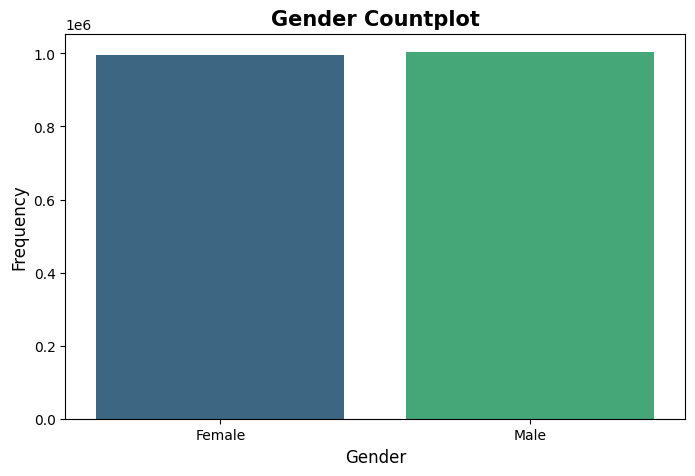

####################################################################################################



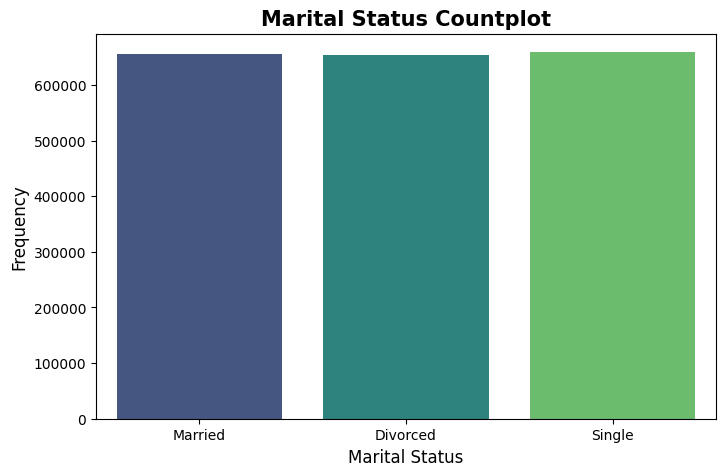

####################################################################################################



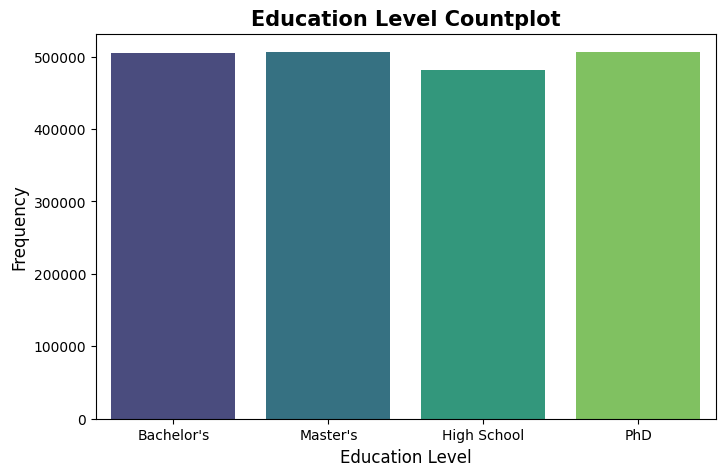

####################################################################################################



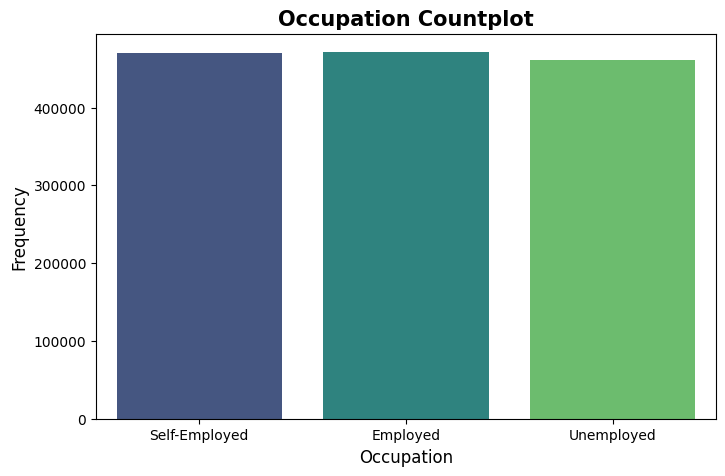

####################################################################################################



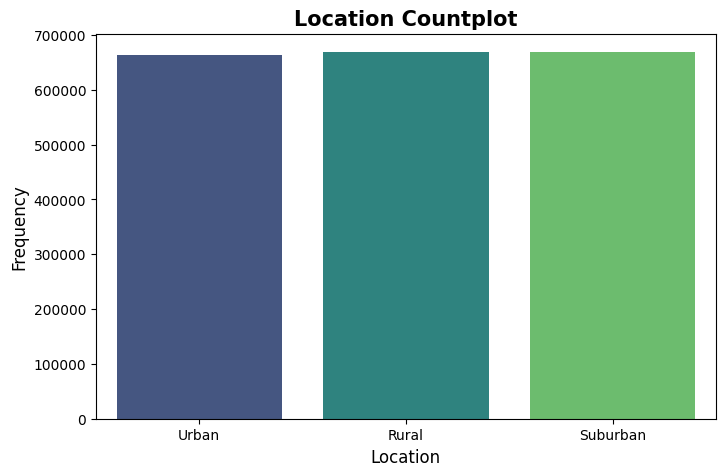

####################################################################################################



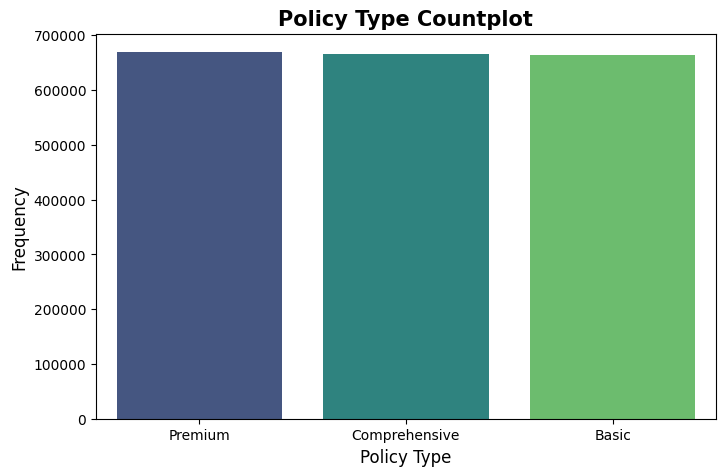

####################################################################################################



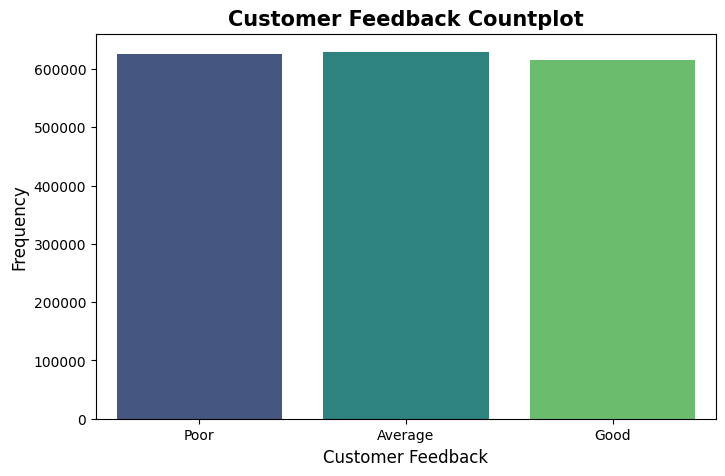

####################################################################################################



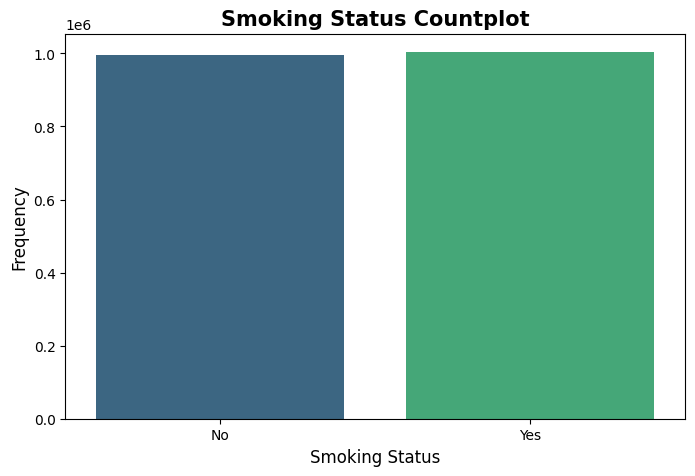

####################################################################################################



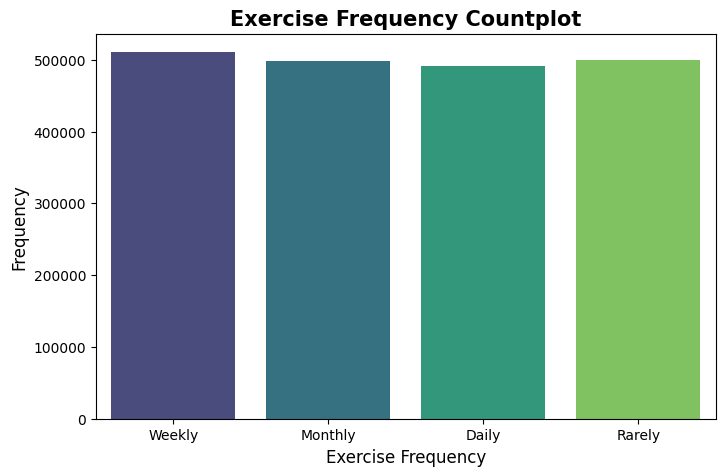

####################################################################################################



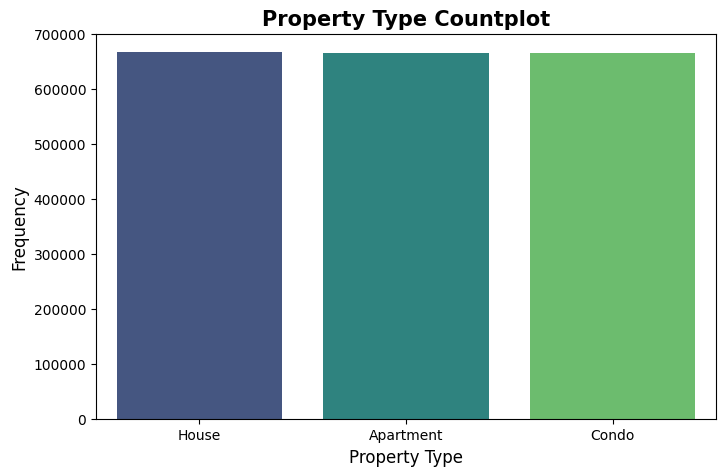

####################################################################################################



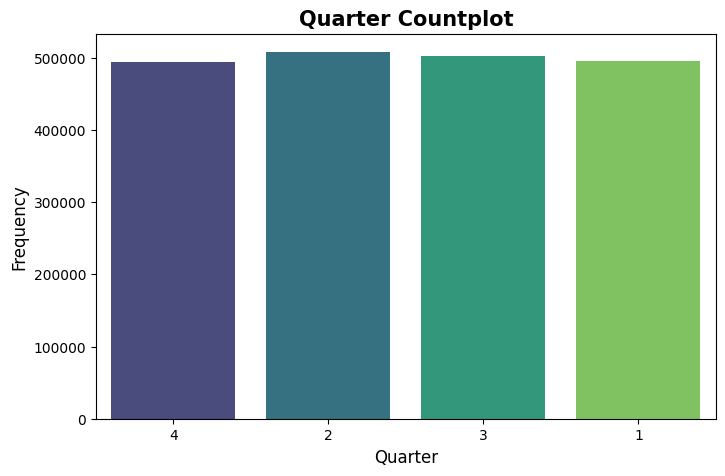

####################################################################################################



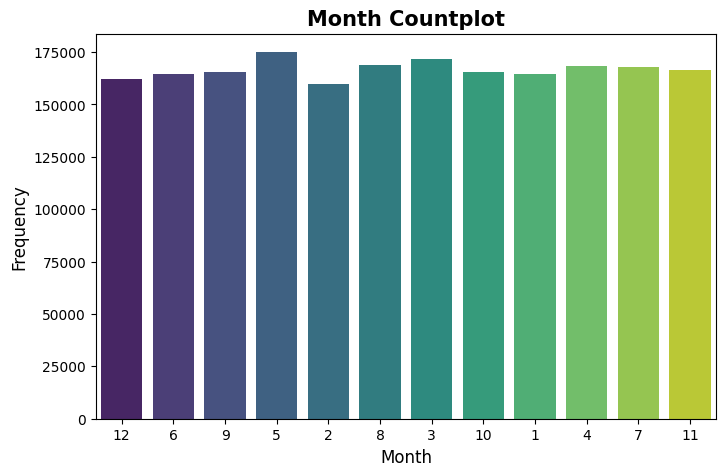

####################################################################################################



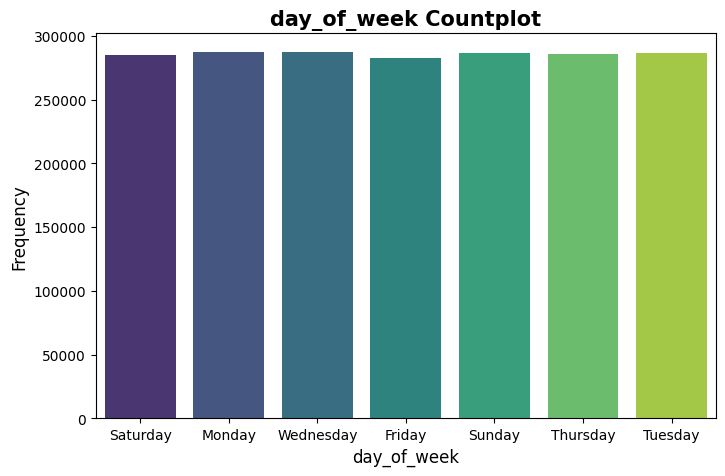

####################################################################################################



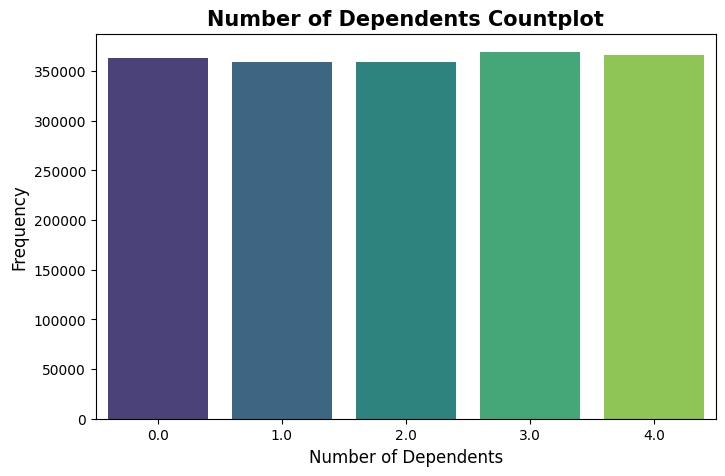

####################################################################################################



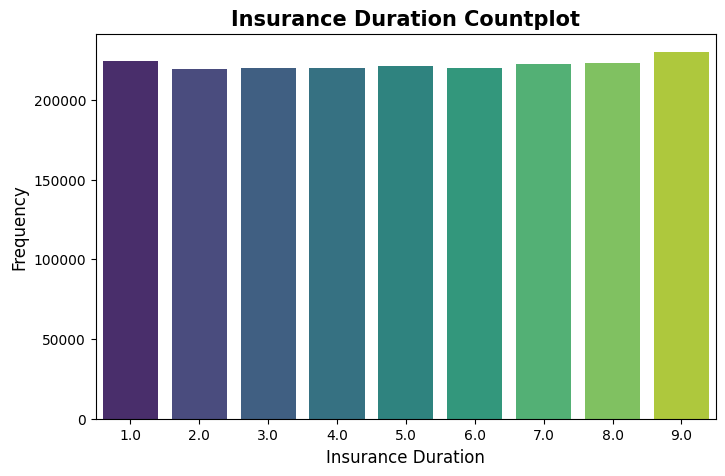

####################################################################################################



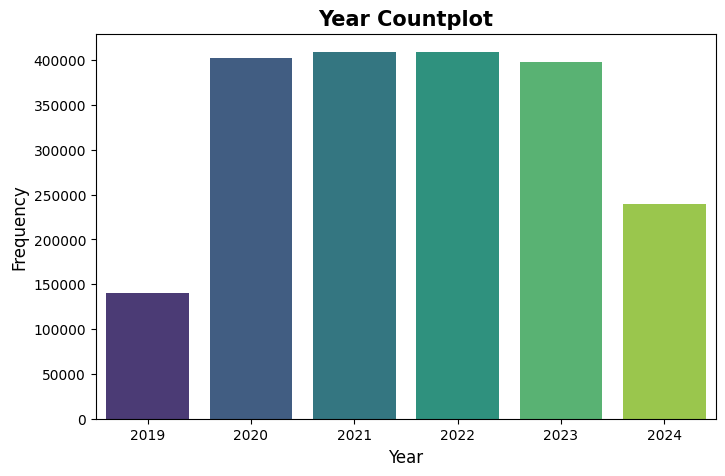

####################################################################################################



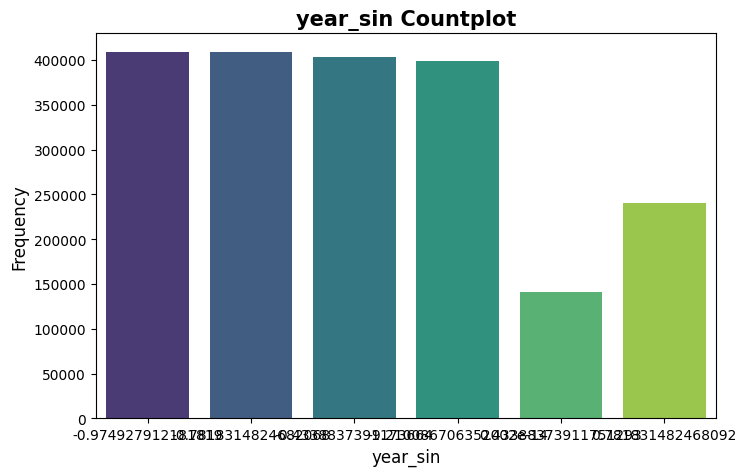

####################################################################################################



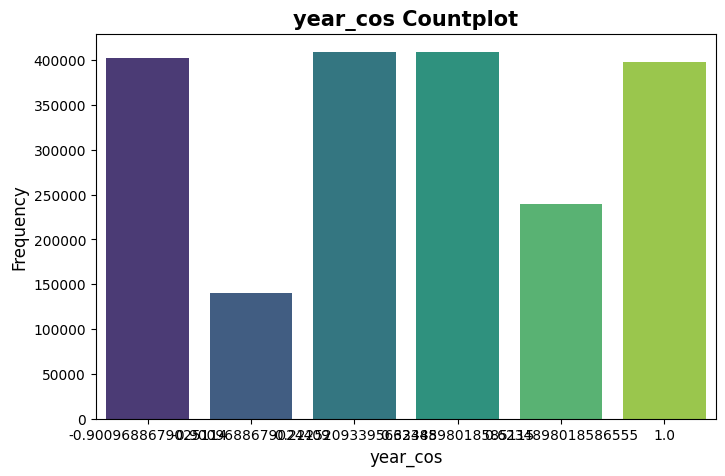

In [55]:
# Plotting Categorical variables
for col in cat_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df,
                  x=col,
                  orient='y',
                  palette='viridis')
    plt.title(f"{col} Countplot", fontsize=15, fontweight='bold')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    print(f"##" * 50 + "\n")
    plt.show()

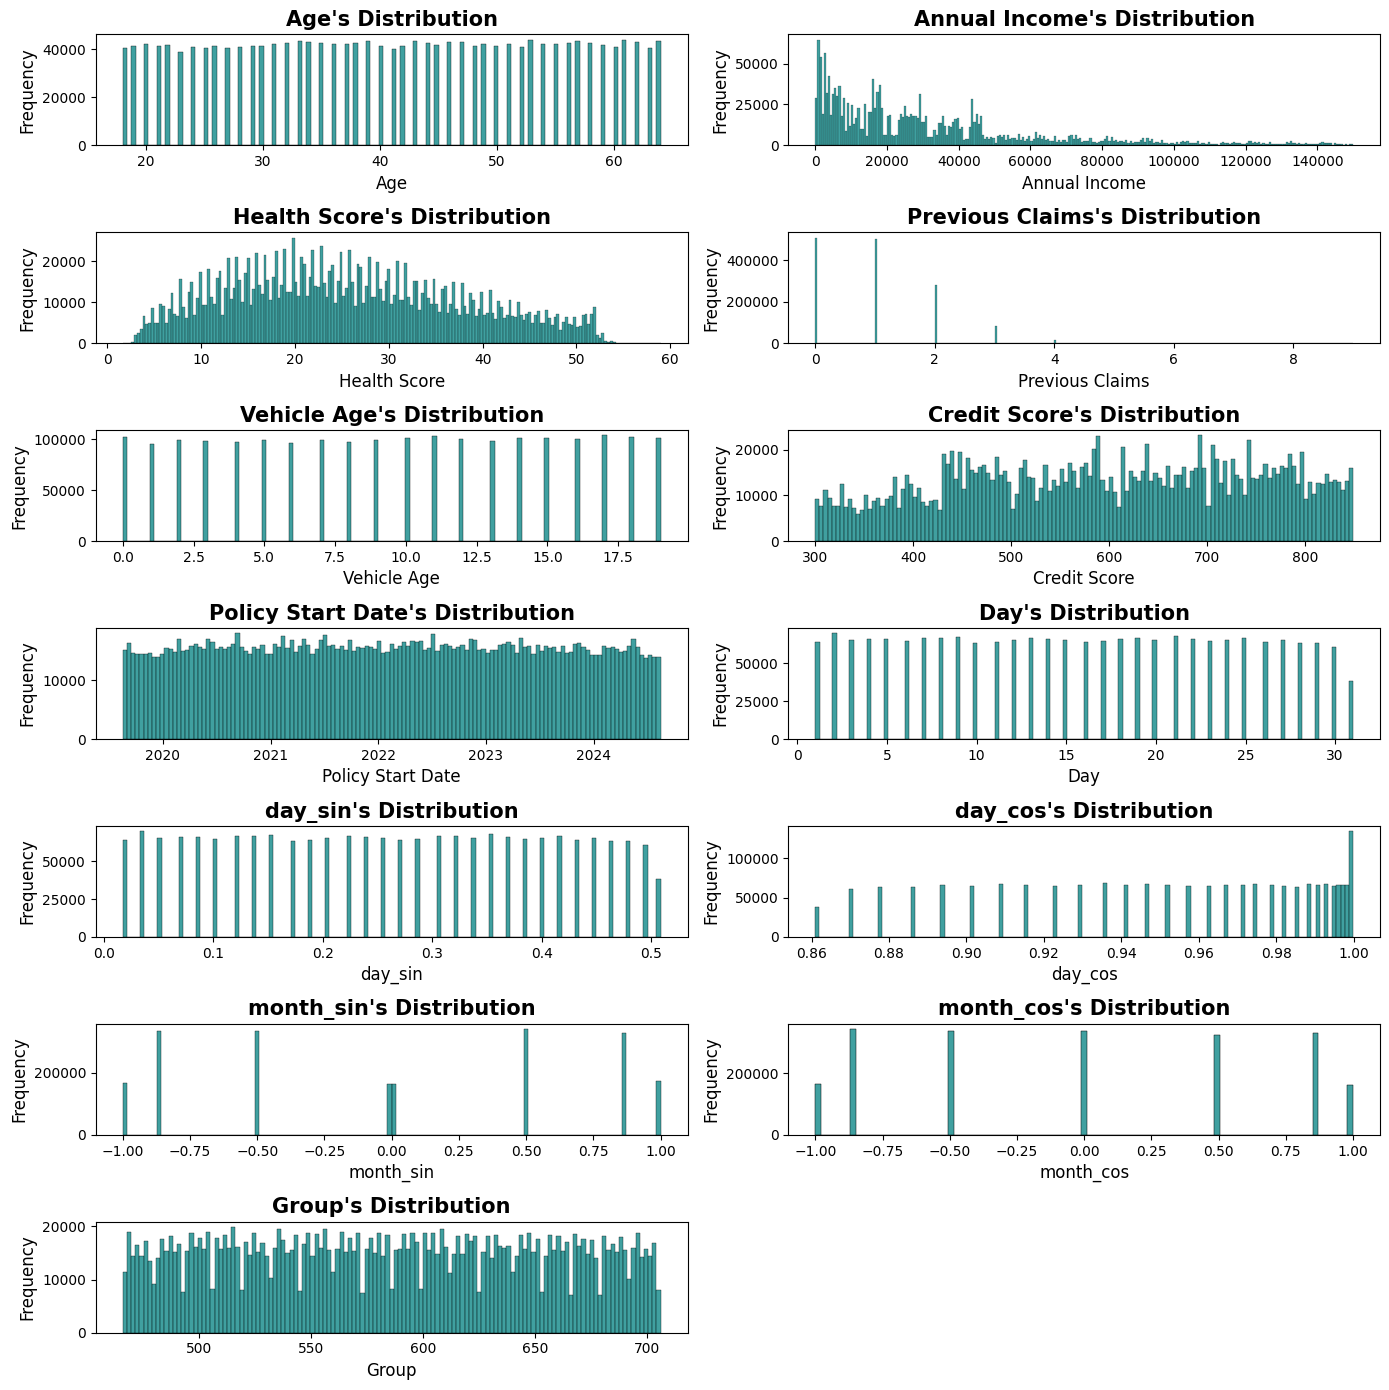

In [58]:
plt.figure(figsize=(14, 14))

for i, col in enumerate(num_cols, 1):
    # Create subplots dynamically
    plt.subplot((len(num_cols) + 1) // 2, 2, i)
    sns.histplot(data=df, x=col, bins='auto', color='teal')

    # Add titles and labels
    plt.title(f"{col}'s Distribution", fontsize=15, fontweight='bold')
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)

# Show all plots
plt.tight_layout()
plt.show()

## Handling Missing Values

In [61]:
columns_with_nan = [col for col in df.columns if df[col].isnull().sum() > 0]
columns_with_nan

['Age',
 'Annual Income',
 'Marital Status',
 'Number of Dependents',
 'Occupation',
 'Health Score',
 'Previous Claims',
 'Vehicle Age',
 'Credit Score',
 'Insurance Duration',
 'Customer Feedback',
 'Premium Amount']

In [68]:
def imputation(df, num_method="median", cat_threshold=20, target="Premium Amount"):
    """
    Perform quick imputation for missing values in a dataset.

    Parameters:
        data (pd.DataFrame): The dataset to process.
        num_method (str): The method for imputing numeric variables ('mean' or 'median'). Default is 'median'.
        cat_threshold (int): The maximum number of unique values in categorical columns for mode-based imputation. Default is 20.
        target (str): The target column to exclude from imputation.

    Returns:
        pd.DataFrame: The dataset with missing values imputed.
    """
    # Cols with NaNs
    variables_with_na = [col for col in df.columns if df[col].isnull().sum() > 0]

    # Store dataframe in temp
    temp_target = df[target].copy()

    print("## BEFORE IMPUTATION ##")
    print(df[variables_with_na].isnull().sum(), "\n")

    # IMPUTE CATEGORICAL COLUMNS WITH "MODE"
    df = df.apply(
        lambda col: col.fillna(col.mode()[0]) if (col.dtype == "O" and col.nunique() <= cat_threshold) else col,
        axis=0
    )

    # IMPUTE NUMERIC COLS BASED ON IMPUTATION METHOD
    if num_method == "mean":
        df = df.apply(
            lambda col: col.fillna(col.mean()) if col.dtype != "O" else col,
                                   axis=0
        )
    if num_method == "median":
        df = df.apply(
            lambda col: col.fillna(col.median()) if col.dtype != "O" else col,
            axis=0
        )
    else:
        raise ValueError("Invalid Method, Please Chose 'mean' or 'median'.")

    # Restore target
    df[target] = temp_target

    print("## AFTER IMPUTATION ##")
    print(f"Imputation method for categorical variables: MODE")
    print(f"Imputation method for numeric variables: {num_method.upper()} \n")
    print(df[variables_with_na].isnull().sum(), "\n")  # Missing values count after imputation

    return df

In [69]:
df = imputation(df, cat_threshold=17)
df.head()

## BEFORE IMPUTATION ##
Age                      31194
Annual Income            74809
Marital Status           30865
Number of Dependents    182802
Occupation              597200
Health Score            123525
Previous Claims         606831
Vehicle Age                  9
Credit Score            229333
Insurance Duration           3
Customer Feedback       130100
Premium Amount          800000
dtype: int64 

# AFTER IMPUTATION
Imputation method for categorical variables: MODE
Imputation method for numeric variables: MEDIAN 

Age                          0
Annual Income                0
Marital Status               0
Number of Dependents         0
Occupation                   0
Health Score                 0
Previous Claims              0
Vehicle Age                  0
Credit Score                 0
Insurance Duration           0
Customer Feedback            0
Premium Amount          800000
dtype: int64 



,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Year,Quarter,Month,Day,day_of_week,week_of_year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,Group
0,0,19.000,Female,10049.000,Married,1.000,Bachelor's,Self-Employed,22.599,Urban,Premium,2.000,17.000,372.000,5.000,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.000,2023,4,12,23,Saturday,51,0.386,0.923,-0.000,1.000,-0.000,1.000,675
1,1,39.000,Female,31678.000,Divorced,3.000,Master's,Employed,15.570,Rural,Comprehensive,1.000,12.000,694.000,2.000,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.000,2023,2,6,12,Monday,24,0.205,0.979,0.000,-1.000,-0.000,1.000,649
2,2,23.000,Male,25602.000,Divorced,3.000,High School,Self-Employed,47.178,Suburban,Premium,1.000,14.000,595.000,3.000,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.000,2023,3,9,30,Saturday,39,0.494,0.870,-1.000,-0.000,-0.000,1.000,664
3,3,21.000,Male,141855.000,Married,2.000,Bachelor's,Employed,10.938,Rural,Basic,1.000,0.000,367.000,1.000,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.000,2024,2,6,12,Wednesday,24,0.205,0.979,0.000,-1.000,0.782,0.623,697
4,4,21.000,Male,39651.000,Single,1.000,Bachelor's,Self-Employed,20.376,Rural,Premium,0.000,8.000,598.000,4.000,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.000,2021,4,12,1,Wednesday,48,0.017,1.000,-0.000,1.000,-0.975,-0.223,576


In [71]:
df.isna().sum()

,0
id,0
Age,0
Gender,0
Annual Income,0
Marital Status,0
Number of Dependents,0
Education Level,0
Occupation,0
Health Score,0
Location,0


## Detect Outliers

In [110]:
def remove_outliers_iqr_all(df):
    """
    Remove outliers from all numeric columns in a DataFrame using the IQR method.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A DataFrame with outliers removed from all numeric columns.
    """
    df_clean = df.copy()  # Work on a copy to avoid modifying the original DataFrame
    numeric_cols = df_clean.select_dtypes(include=np.number).columns  # Select numeric columns

    for col in numeric_cols:
        # Skip processing if the column is empty
        if df_clean[col].dropna().empty:
            print(f"Skipping column {col} because it's empty or has all NaN values.")
            continue

        # Calculate Quantiles
        Q1 = np.quantile(df_clean[col].dropna(), 0.25)
        Q3 = np.quantile(df_clean[col].dropna(), 0.75)
        IQR = Q3 - Q1

        # Define boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove rows with outliers in the current column
        rows_before = df_clean.shape[0]
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        rows_removed = rows_before - df_clean.shape[0]

        print(f"Column: {col}")
        print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
        print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
        print(f"Number of rows removed for {col}: {rows_removed}")
        print("----" * 30 + "\n")

        # Stop processing if the DataFrame becomes empty
        if df_clean.empty:
            print("The DataFrame is empty after processing. Stopping further outlier removal.")
            break

    return df_clean


In [111]:
df_cleaned = remove_outliers_iqr_all(df)

Column: id
Q1: 499999.75, Q3: 1499999.25, IQR: 999999.5
Lower Bound: -999999.5, Upper Bound: 2999998.5
Number of rows removed for id: 0
------------------------------------------------------------------------------------------------------------------------

Column: Age
Q1: 30.0, Q3: 53.0, IQR: 23.0
Lower Bound: -4.5, Upper Bound: 87.5
Number of rows removed for Age: 0
------------------------------------------------------------------------------------------------------------------------

Column: Annual Income
Q1: 8662.0, Q3: 43940.0, IQR: 35278.0
Lower Bound: -44255.0, Upper Bound: 96857.0
Number of rows removed for Annual Income: 117719
------------------------------------------------------------------------------------------------------------------------

Column: Number of Dependents
Q1: 1.0, Q3: 3.0, IQR: 2.0
Lower Bound: -2.0, Upper Bound: 6.0
Number of rows removed for Number of Dependents: 0
-----------------------------------------------------------------------------------------